# Setup

In [17]:
from pathlib import Path
import platform
import os
import shutil
import time
import numpy as np
import pandas
from pprint import pprint
import matplotlib.pylab as plt
import spikeinterface.full as si    # may need to run pip install in the spikeinterface folder first
import probeinterface as pi
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# import ipywidgets
%matplotlib widget

# Import my custom modules
from src import spikeinterface_hp 
# from src import rhdutilities 
from src import load_probe_rhd 
import importlib  # Allow module reloads in case any changes were made after starting the kernel: importlib.reload(spikeinterface_hp)

# Add path to kilosort2 and ironclust repos
si.Kilosort2Sorter.set_kilosort2_path(Path.resolve(Path('../../Kilosort-2.0')))
si.IronClustSorter.set_ironclust_path(Path.resolve(Path('../../ironclust')))

# Print SI version
print(f"SpikeInterface version: {si.__version__}")

# Print list of installed sorters
print(si.installed_sorters())

Setting KILOSORT2_PATH environment variable for subprocess calls to: D:\hannah\Dropbox\code\spikesort\kilosort-2.0
Setting IRONCLUST_PATH environment variable for subprocess calls to: D:\hannah\Dropbox\code\spikesort\ironclust
SpikeInterface version: 0.95.1.dev0
RUNNING SHELL SCRIPT: C:\Users\Hannah\AppData\Local\Temp\tmp_shellscriptm2dtlhpv\script.bat
RUNNING SHELL SCRIPT: C:\Users\Hannah\AppData\Local\Temp\tmp_shellscriptxc2ct6ys\script.bat
RUNNING SHELL SCRIPT: C:\Users\Hannah\AppData\Local\Temp\tmp_shellscript3eokg101\script.bat
RUNNING SHELL SCRIPT: C:\Users\Hannah\AppData\Local\Temp\tmp_shellscriptcdpm4u9l\script.bat
RUNNING SHELL SCRIPT: C:\Users\Hannah\AppData\Local\Temp\tmp_shellscriptrxuvu6w5\script.bat
RUNNING SHELL SCRIPT: C:\Users\Hannah\AppData\Local\Temp\tmp_shellscriptcukx_ctj\script.bat
RUNNING SHELL SCRIPT: C:\Users\Hannah\AppData\Local\Temp\tmp_shellscript_8ik98hk\script.bat
RUNNING SHELL SCRIPT: C:\Users\Hannah\AppData\Local\Temp\tmp_shellscriptymn1akym\script.bat
[

Option 1: Make toy example recording data in the results folder

In [18]:
# Set paths that are used throughout: results and data
results_path = Path.resolve(Path('..','results')) 
print(results_path)
data_path = results_path/'toy_example_recording'
print(data_path)

# Make the toy example in the data folder
if not data_path.exists():
    recording, sorting = si.toy_example(num_segments=1, duration=100, seed=1, num_channels=16, num_columns=2)
    recording.save(folder=data_path)
    print('Created toy data')
else:
    print('Toy data already exists')

recording = si.load_extractor(data_path)
recording_cmr = recording # It is already filtered and common median filtered

D:\hannah\Dropbox\code\spikesort\spikesort-hp\results
D:\hannah\Dropbox\code\spikesort\spikesort-hp\results\toy_example_recording
Toy data already exists


Option 2: Load REAL data from the server

Z:\Hannah\ephys\project2\HC05_220819\raw_220819_125309

Reading Intan Technologies RHD2000 Data File, Version 3.0

Found 32 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 2 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Header file contains no data.  Amplifiers were sampled at 30.00 kS/s.
Done!  Elapsed time: 0.1 seconds
       x      y contact_ids shank_ids  device_channel_indices
0    0.0  375.0                     0                       0
1   22.5  262.5                     0                       1
2   22.5  312.5                     0                       2
3   22.5  187.5                     0                       3
4    0.0  175.0                     0                       4
5    0.0  125.0                     0                       5
6    0.0  300.0                     0                       6
7   22.5   62.5                     0         

(<matplotlib.collections.PolyCollection at 0x23d0b66a6d0>, None)

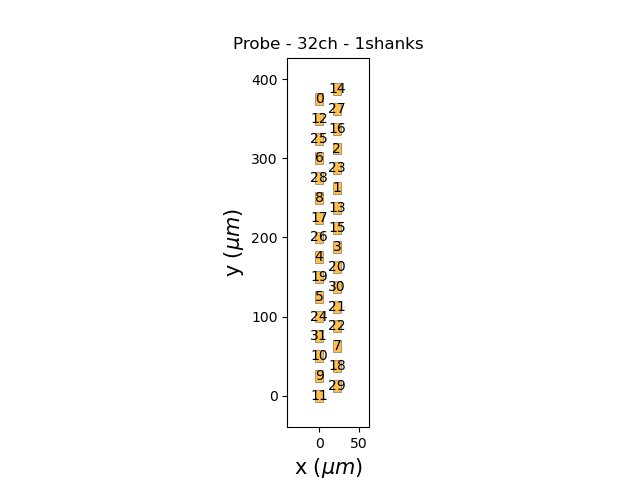

In [19]:
# Set paths that are used throughout: results and data
results_path = Path('Z:/Hannah/ephys/project2/HC05_220819')   #  A 32 channel recording, shank A only
# results_path = Path('Z:/Hannah/ephys/project2/test_rec')    # A short 64 channel recording (all noise, no real spikes)
data_path = [f for f in results_path.iterdir() if f.is_dir() and f.name.startswith('raw')] # subfolder starting with raw*. Should only be one!
data_path = data_path[0] # Set data_path to the folder containing the intan.rhd file etc
print(data_path)

importlib.reload(spikeinterface_hp)
recording_raw = spikeinterface_hp.read_intan_dat(data_path)

# Load the probe for this file
importlib.reload(load_probe_rhd)
probe = load_probe_rhd.H6(data_path/'info.rhd', results_path/'probe.json')
recording_raw = recording_raw.set_probe(probe, group_mode="by_shank")

# Visualizations/checks
probe = recording_raw.get_probe() # sorts by index in .dat file
print(probe.to_dataframe(complete=True).loc[:, ['x','y','contact_ids', 'shank_ids', 'device_channel_indices']])
pi.plotting.plot_probe(probe, with_channel_index=True) 
# pi.plotting.plot_probe(probe, with_device_index=True) # Now the channel index matches the device index bc it was sorted


Using a built in probe:

In [20]:
# # Built-in probe
# manufacturer = 'cambridgeneurotech'
# probe_name = 'ASSY-236-H6'
# probe = pi.get_probe(manufacturer, probe_name)  

# # map channels to device indices
# mapping_to_device = [
# 53,55,61,63,62,60,58,56,54,52,50,46,48,47,43,45,57,59,42,40,38,36,34,44,32,30,28,26,24,22,23,27,51,49,0,2,4,6,8,7,10,12,14,16,18,20,21,19,41,39,37,35,33,31,29,25,17,9,11,15,13,5,3,1
# ]
# probe.set_device_channel_indices(mapping_to_device)
# # probe.wiring_to_device('ASSY-236>RHD2164') # Built-in

# fig, ax = plt.subplots()
# pi.plotting.plot_probe(probe, with_device_index=True, ax=ax) # with_contact_id=True

# print(probe.to_dataframe(complete=True).loc[:, ['x','y','contact_ids', 'shank_ids', 'device_channel_indices']])

# # Load the probeinterface object to the SI recording object:
# recording = recording_raw.set_probe(probe, group_mode="by_shank")

# # When loading the probe, it is automatically sorted by device indices (the order the data is stored on disk):
# probe_rec = recording.get_probe()
# print(probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]])
# print("Properties after loading the probe:", list(recording.get_property_keys()))


Bandpass filter and apply common median reference

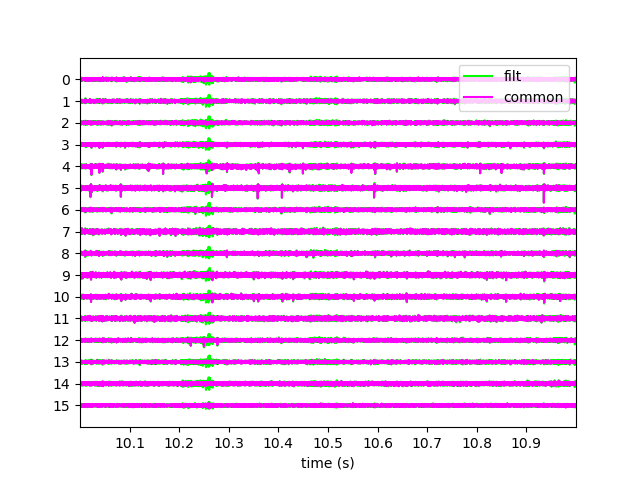

In [21]:

recording_f = si.bandpass_filter(recording_raw, freq_min=300, freq_max=10000)
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')

# Plot the traces after applying CMR:
# w = si.plot_timeseries({"filt": recording_f, "common": recording_cmr}, # "raw": recording_raw,
#   clim=(-1000, 1000), order_channel_by_depth=False,show_channel_ids=True, backend="ipywidgets") #ipywidgets only works in browser - run jupyter notebook in anaconda prompt
w = si.plot_timeseries({"filt": recording_f, "common": recording_cmr},
    order_channel_by_depth=False, time_range=[10,11], channel_ids=range(16), show_channel_ids=True)
# Note: if order_by_channel_depth=True, the order is messed up between the two inputs!

# Run spikesorting
Run Kilosort on the test data: 

Note: make sure your startup.m file in Matlab doesn't change the current directory!

Change Kilosort2 params

In [22]:
default_kilosort2_params = si.Kilosort2Sorter.default_params()
pprint(default_kilosort2_params)
# default_kilosort2_params['freq_min'] = 300            # SC setting: 0=300
# default_kilosort2_params['minfr_goodchannels'] = 0    # SC setting: 0
# default_kilosort2_params['reorder'] = 0 # Can't access this?
#TODO: increase batch size to avoid losing sparsely active cells?
#TODO: turn off filtering and CMR if we are already doing that once? 
# default_kilosort2_params['car'] = False

{'NT': None,
 'car': True,
 'chunk_duration': '1s',
 'chunk_memory': None,
 'chunk_size': None,
 'detect_threshold': 6,
 'freq_min': 150,
 'keep_good_only': False,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'nPCs': 3,
 'n_jobs': 1,
 'nfilt_factor': 4,
 'ntbuff': 64,
 'preclust_threshold': 8,
 'progress_bar': True,
 'projection_threshold': [10, 4],
 'sigmaMask': 30,
 'total_memory': None,
 'wave_length': 61}


Run kilosort2

In [23]:
# Run sorter
sorter_name = 'kilosort2'
output_folder = results_path/(sorter_name+'_output')
print(output_folder)
sorting = si.run_sorter(sorter_name, recording_raw, output_folder, verbose=True, remove_existing_folder=True) # **default_kilosort2_params. Use recording_cmr instead??
print(sorting)

# Get waveforms
waveform_folder = results_path/(sorter_name+'_waveforms')
print(waveform_folder)
si.extract_waveforms(recording_cmr, sorting, waveform_folder,
    n_jobs=1, total_memory="10M", max_spikes_per_unit=500, return_scaled=False, overwrite=True)

# Export to Phy
we = si.WaveformExtractor.load_from_folder(waveform_folder)
phy_folder =  results_path/(sorter_name+'_phy')
print(phy_folder)
si.export_to_phy(we, output_folder=phy_folder, verbose=False, remove_if_exists=True)

Z:\Hannah\ephys\project2\HC05_220819\kilosort2_output
RUNNING SHELL SCRIPT: C:\Users\Hannah\AppData\Local\Temp\tmp_shellscriptgdixvhe9\script.bat
RUNNING SHELL SCRIPT: C:\Users\Hannah\AppData\Local\Temp\tmp_shellscriptrozqjd6e\script.bat
RUNNING SHELL SCRIPT: C:\Users\Hannah\AppData\Local\Temp\tmp_shellscript4k35j6na\script.bat
RUNNING SHELL SCRIPT: Z:\Hannah\ephys\project2\HC05_220819\kilosort2_output\run_kilosort2.bat


(si_env) d:\hannah\Dropbox\code\spikesort\spikesort-hp\scripts>Z:



(si_env) Z:\>cd Z:\Hannah\ephys\project2\HC05_220819\kilosort2_output 



(si_env) Z:\Hannah\ephys\project2\HC05_220819\kilosort2_output>matlab -nosplash -wait -r "kilosort2_master('Z:\Hannah\ephys\project2\HC05_220819\kilosort2_output', 'D:\hannah\Dropbox\code\spikesort\kilosort-2.0')" 

kilosort2 run time 1062.06s
KiloSortSortingExtractor: 39 units - 1 segments - 30.0kHz
Z:\Hannah\ephys\project2\HC05_220819\kilosort2_waveforms


Run Ironclust

In [ ]:
# Run sorter
sorter_name = 'ironclust'
output_folder = results_path/(sorter_name+'_output')
print(output_folder)
sorting = si.run_sorter(sorter_name, recording_raw, output_folder, verbose=True, remove_existing_folder=True)
print(sorting)

# Get waveforms
waveform_folder = results_path/(sorter_name+'_waveforms')
print(waveform_folder)
si.extract_waveforms(recording_cmr, sorting, waveform_folder,
    n_jobs=1, total_memory="10M", max_spikes_per_unit=500, return_scaled=False, overwrite=True)

# Export to Phy
we = si.WaveformExtractor.load_from_folder(waveform_folder)
phy_folder = results_path/(sorter_name+'_phy')
print(phy_folder)
si.export_to_phy(we, output_folder=phy_folder, verbose=False, remove_if_exists=True)

# Post-processing

Calculate quality metrics for each sorter

In [ ]:
# Load waveforms
we_ks = si.WaveformExtractor.load_from_folder(results_path/'kilosort2_waveforms')
we_ic = si.WaveformExtractor.load_from_folder(results_path/'ironclust_waveforms')

# Compute quality metrics
metric_names=['snr', 'isi_violation', 'amplitude_cutoff','isolation_distance']
metrics_ks = si.compute_quality_metrics(we_ks, metric_names)
metrics_ic = si.compute_quality_metrics(we_ic, metric_names)
print(metrics_ks)
print(metrics_ic)

#assert 'isolation_distance' in metrics_ks.columns
# not sure why isolation distance isn't showing up for ic

Find agreement between sorters

In [ ]:
# Load sorting
sorting_ks = si.read_phy(results_path/'kilosort2_phy')
sorting_ic = si.read_phy(results_path/'ironclust_phy')

# Option 1: Compare with one as reference
comp_ks_ic = si.compare_two_sorters(sorting1=sorting_ks, sorting2=sorting_ic)

print('Relative to Kilosort2:')
print(comp_ks_ic.hungarian_match_12)

print('Relative to Ironclust:')
print(comp_ks_ic.hungarian_match_21)

In [ ]:
# Option 2: Find consensus
comp_multi = si.compare_multiple_sorters(sorting_list=[sorting_ks, sorting_ic],
                                         name_list=['ks', 'ic'])

output_folder = results_path/'consensus_output'
sorting_agreement = comp_multi.get_agreement_sorting(minimum_agreement_count=2)
sorting_agreement_saved = sorting_agreement.save(folder=output_folder)

print('Units in agreement:', sorting_agreement_saved.get_unit_ids())
# w_multi = si.plot_multicomp_graph(comp_multi)
# plt.show() # not working correctly

Export consensus agreement to Phy

In [ ]:
# Get waveforms
waveform_folder = results_path/'consensus_waveforms'
si.extract_waveforms(recording_cmr, sorting_agreement_saved, waveform_folder,
    n_jobs=1, chunk_duration="1s", max_spikes_per_unit=500, return_scaled=False, overwrite=True)
# Q: difference between total_memory="10M",  or chunk_duration="1s" in extract_waveforms?

# Extract waveforms
we = si.WaveformExtractor.load_from_folder(waveform_folder)

# Export to PHy
phy_folder = results_path/'consensus_phy'
print(phy_folder)
si.export_to_phy(we, output_folder=phy_folder, verbose=False, remove_if_exists=True)

In [ ]:
# Launch Phy
from phy.apps.template import template_gui
template_gui(phy_folder/'params.py')